# Multimodal Language Models: Customizing PaliGemma 2 for JSON Extraction

In this Colab notebook, we explore a real-world application of multimodal models by fine-tuning **PaliGemma 2** to extract structured JSON information from images. PaliGemma 2 merges the **SigLIP-So400m** image encoder with the **Gemma 2** language model, enabling seamless interaction between visual and textual data.

## Topics Covered:
1. Overview of the PaliGemma 2 architecture
2. Setting up the environment and installing necessary packages
3. Preparing the dataset for fine-tuning
4. Training with efficient parameter tuning methods (LoRA/QLoRA)
5. Model evaluation on validation/test data
6. Performing inference with the trained model

This model is particularly effective for tasks involving structured data extraction from visual content—such as digitizing receipts, parsing documents, or interpreting technical illustrations into JSON format.

## 1. Installing Dependencies


In [1]:
!pip install lightning jsonlines

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 2. Import Libraries and Verify GPU Access

In this section, we import all the necessary Python libraries and verify that a GPU is available in the current environment. Utilizing a GPU is important for speeding up model training and inference, especially when working with large-scale multimodal models like PaliGemma 2.


In [2]:
# Import necessary modules
import os
import json
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import lightning as L
from datasets import load_dataset
import jsonlines
from tqdm.auto import tqdm
from transformers import (
    AutoTokenizer,
    AutoProcessor,
    AutoModelForVision2Seq,
    TrainingArguments
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training
)
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Print whether CUDA (GPU support) is available
print(f"CUDA available: {torch.cuda.is_available()}")

# If CUDA is available, print details about the GPU
if torch.cuda.is_available():
    # Print GPU model name
    print(f"GPU model: {torch.cuda.get_device_name(0)}")
    # Print memory currently allocated on the GPU
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1e9:.2f} GB")
    # Print total memory reserved on the GPU
    print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1e9:.2f} GB")


CUDA available: True
GPU model: Tesla T4
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB


## 3. Overview of PaliGemma 2 Architecture

PaliGemma 2 is a multimodal model created by Google that integrates two core components:

1. **Image Encoder**: SigLIP-So400m, capable of handling image resolutions such as 224px, 448px, and 896px.
2. **Text Generator**: Gemma 2 language model, available in sizes ranging from 2 billion to 27 billion parameters.

The model functions by:
- Feeding the input image into the vision encoder to extract visual tokens.
- Projecting these tokens and merging them with the input text tokens.
- Passing the combined tokens to the language model to produce output that reflects both image and text context.

For this notebook, we’ll use the 3B version of the model with 224px images, which offers a good balance between performance and resource efficiency.


In [ ]:
# Set the identifier for the pre-trained model to be used
MODEL_ID = "google/paligemma-3b-pt-224"

# Define maximum token sequence length for model input
MAX_LENGTH = 512

# Define image resolution expected by the model
IMAGE_SIZE = 224

# Set number of samples per training batch
BATCH_SIZE = 4

# Define how many batches to accumulate before a backward pass
GRADIENT_ACCUMULATION_STEPS = 4

# Initialize LoRA (Low-Rank Adaptation) configuration for efficient fine-tuning
lora_config = LoraConfig(
    r=16,  # Set rank of LoRA matrices
    lora_alpha=32,  # Define LoRA scaling factor
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Specify layers for LoRA injection
    lora_dropout=0.05,  # Apply dropout to LoRA layers
    bias="none",  # Disable bias parameter updates
    task_type="CAUSAL_LM"  # Specify the model's task type
)

# Print the selected model ID
print(f"Using model: {MODEL_ID}")

# Print key parameters from LoRA configuration
print(f"LoRA configuration: rank={lora_config.r}, alpha={lora_config.lora_alpha}")

# Print the names of the target modules for LoRA application
print(f"Target modules: {lora_config.target_modules}")


## 4. Preparing and Loading the Dataset

To illustrate JSON extraction, we’ll use a synthetic dataset created specifically for this tutorial. The dataset consists of images containing basic colored shapes, and the task is to convert the visual content into a structured JSON format describing the shapes.


In [3]:
# Create directory for saving synthetic dataset
!mkdir -p data/shapes_dataset

In [4]:
# Import required libraries for image generation and JSON handling
from PIL import Image, ImageDraw
import base64
import io
import random
import json

# Define function to decode a base64-encoded image string to a PIL Image
def decode_base64_image(base64_string):
    import base64
    from io import BytesIO
    image_data = base64.b64decode(base64_string)
    image = Image.open(BytesIO(image_data))
    return image

# Define function to generate an image with random shapes and metadata
def create_synthetic_image(width=224, height=224, num_shapes=3):
    image = Image.new('RGB', (width, height), (255, 255, 255))  # Create blank white image
    draw = ImageDraw.Draw(image)

    colors = ['red', 'green', 'blue', 'yellow', 'purple']  # Available shape colors
    shapes = ['circle', 'rectangle', 'triangle']  # Available shape types

    color_map = {  # RGB values for colors
        'red': (255, 0, 0),
        'green': (0, 255, 0),
        'blue': (0, 0, 255),
        'yellow': (255, 255, 0),
        'purple': (128, 0, 128)
    }

    shape_info = []  # Store metadata for each shape

    # Draw random shapes with random attributes
    for i in range(num_shapes):
        shape_type = random.choice(shapes)
        color_name = random.choice(colors)
        color_rgb = color_map[color_name]

        x = random.randint(20, width - 60)  # Random x-position
        y = random.randint(20, height - 60)  # Random y-position
        size = random.randint(30, 50)  # Random shape size

        if shape_type == 'circle':
            draw.ellipse((x, y, x + size, y + size), fill=color_rgb)
        elif shape_type == 'rectangle':
            draw.rectangle((x, y, x + size, y + size), fill=color_rgb)
        elif shape_type == 'triangle':
            draw.polygon([(x, y + size), (x + size, y + size), (x + size/2, y)], fill=color_rgb)

        shape_info.append({  # Store shape metadata
            "type": shape_type,
            "color": color_name,
            "position": {"x": x, "y": y},
            "size": size
        })

    return image, shape_info

In [5]:
# Define function to encode a PIL image as base64 string
def encode_image_base64(image):
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")
    return base64.b64encode(buffer.getvalue()).decode('utf-8')

# Set number of synthetic examples to generate
num_samples = 50
dataset = []

# Generate synthetic data samples
for i in range(num_samples):
    num_shapes = random.randint(1, 5)  # Random number of shapes per image
    image, shape_info = create_synthetic_image(num_shapes=num_shapes)

    json_data = {  # Build target JSON structure
        "shapes": shape_info,
        "total_count": len(shape_info),
        "image_id": f"img_{i}",
        "timestamp": "2025-05-13T12:00:00Z"
    }

    entry = {  # Construct JSONL record
        "image": encode_image_base64(image),
        "prefix": "Extract all shape information from this image and return as JSON.",
        "suffix": json.dumps(json_data, indent=2)
    }

    dataset.append(entry)

# Shuffle and split dataset into train, val, and test
random.shuffle(dataset)
train_split = int(0.7 * num_samples)
val_split = int(0.85 * num_samples)

train_data = dataset[:train_split]
val_data = dataset[train_split:val_split]
test_data = dataset[val_split:]

# Define function to save a list of JSON records to a JSONL file
def save_jsonl(data, file_path):
    with open(file_path, 'w') as f:
        for item in data:
            f.write(json.dumps(item) + '\n')

# Save the train, validation, and test splits
save_jsonl(train_data, 'data/shapes_dataset/train.jsonl')
save_jsonl(val_data, 'data/shapes_dataset/val.jsonl')
save_jsonl(test_data, 'data/shapes_dataset/test.jsonl')


Created dataset with 35 training, 7 validation, and 8 test samples


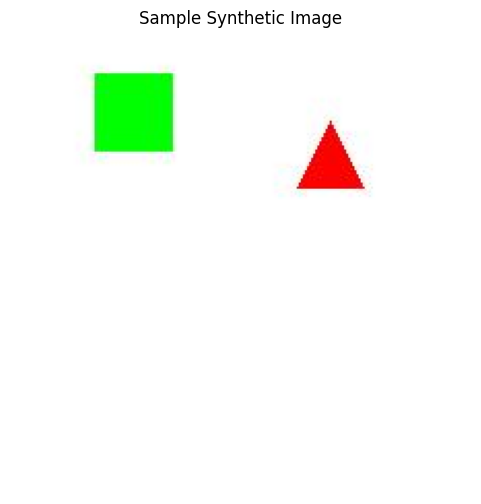

Prompt: Extract all shape information from this image and return as JSON.
Target JSON (first 200 chars): {
  "shapes": [
    {
      "type": "rectangle",
      "color": "green",
      "position": {
        "x": 41,
        "y": 20
      },
      "size": 37
    },
    {
      "type": "triangle",
      "co...


In [6]:
# Print summary of dataset sizes
print(f"Created dataset with {len(train_data)} training, {len(val_data)} validation, and {len(test_data)} test samples")

# Decode and display a sample image from training data
sample = train_data[0]
sample_image = decode_base64_image(sample['image'])

plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.axis('off')
plt.title("Sample Synthetic Image")
plt.show()

# Print prompt and truncated ground truth JSON
print(f"Prompt: {sample['prefix']}")
print(f"Target JSON (first 200 chars): {sample['suffix'][:200]}...")

# Set file paths for future use
train_path = 'data/shapes_dataset/train.jsonl'
val_path = 'data/shapes_dataset/val.jsonl'
test_path = 'data/shapes_dataset/test.jsonl'

## 5. Defining a Custom Dataset Class

To manage our multimodal dataset effectively, we’ll define a custom dataset class. This class will:
- Read data from a JSONL file
- Prepare images and corresponding text for model input
- Apply necessary tokenization and formatting for training


In [ ]:
# Define a custom dataset class compatible with PaliGemma
class PaliGemmaDataset(Dataset):
    def __init__(self, jsonl_file, processor, max_length=512):
        # Initialize dataset list, processor, and max sequence length
        self.data = []
        self.processor = processor
        self.max_length = max_length

        # Read and parse each line from the JSONL file
        with open(jsonl_file, 'r') as f:
            for line in f:
                self.data.append(json.loads(line))

        # Print the number of loaded examples
        print(f"Loaded {len(self.data)} examples from {jsonl_file}")

    # Return the total number of examples
    def __len__(self):
        return len(self.data)

    # Define how each example is accessed
    def __getitem__(self, idx):
        item = self.data[idx]

        # Convert base64 string back into an image
        image = decode_base64_image(item['image'])

        # Concatenate prefix and suffix text for input
        prefix = item['prefix']
        suffix = item['suffix']
        text = prefix + suffix

        # Process image and text into model-ready format
        encoding = self.processor(
            images=image,
            text=text,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        # Remove batch dimension from tensors
        for k, v in encoding.items():
            if isinstance(v, torch.Tensor) and v.ndim > 0:
                encoding[k] = v.squeeze(0)

        # Copy input IDs for use as labels
        labels = encoding["input_ids"].clone()

        # Process prefix separately to determine its length
        prefix_encoding = self.processor(
            text=prefix,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
            return_tensors="pt"
        )

        # Identify length of the prefix (excluding padding)
        prefix_len = (prefix_encoding.input_ids[0] != self.processor.tokenizer.pad_token_id).sum()

        # Mask out prefix tokens from contributing to loss
        labels[:prefix_len] = -100

        # Mask padding tokens in labels
        labels[labels == self.processor.tokenizer.pad_token_id] = -100

        # Add labels to encoding dictionary
        encoding["labels"] = labels

        return encoding


## 6. Load the Model and Processor

Next, we load the PaliGemma 2 model along with its processor. The processor is responsible for preparing inputs—handling image transformations (like resizing and normalization) and tokenizing text data.

To enable efficient fine-tuning, we'll use **LoRA (Low-Rank Adaptation)**. This method reduces memory usage by updating a lightweight set of additional parameters instead of modifying the entire model, making it ideal for training large models on limited hardware.


In [ ]:
# Import login function for Hugging Face Hub authentication
from huggingface_hub import login

# Import Colab's secure user data module
from google.colab import userdata

# Retrieve Hugging Face token from Colab's secure storage
HF_TOKEN = userdata.get('HF_TOKEN')

# Authenticate with Hugging Face if token is available
if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    # Prompt user if token is missing
    print("Token is not set. Please save the token first.")


Successfully logged in to Hugging Face!


In [ ]:
# Load processor (tokenizer + image processor) from pre-trained model
processor = AutoProcessor.from_pretrained(MODEL_ID)

# Load vision-to-sequence model with reduced precision and automatic device mapping
model = AutoModelForVision2Seq.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# Set padding, start, and end token IDs from tokenizer to model config
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.bos_token_id
model.config.eos_token_id = processor.tokenizer.eos_token_id

# Prepare model for quantized training (e.g., 8-bit) using LoRA
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

# Compute and print number of trainable parameters after applying LoRA
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.2%} of {total_params:,} total)")

# Instantiate training and validation datasets
train_dataset = PaliGemmaDataset(train_path, processor, max_length=MAX_LENGTH)
val_dataset = PaliGemmaDataset(val_path, processor, max_length=MAX_LENGTH)


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

Trainable parameters: 6,672,384 (0.23% of 2,930,138,864 total)
Loaded 35 examples from data/shapes_dataset/train.jsonl
Loaded 7 examples from data/shapes_dataset/val.jsonl


## 7. Building the Lightning Module for Training

We'll utilize PyTorch Lightning to structure our training process. The Lightning module includes:
- The model’s forward pass and loss computation
- Optimizer setup
- Training and validation step definitions
- Metric tracking

Using this modular approach improves code clarity and makes it easier to manage and scale.


In [ ]:
# Define a PyTorch Lightning module for fine-tuning the PaliGemma model
class PaliGemmaFinetuner(L.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model  # Store the model
        self.config = config  # Store training config
        self.batch_size = config.get("batch_size", 4)  # Default batch size

    # Define the forward pass
    def forward(self, batch):
        output = self.model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"],
        )
        return output.loss, output.logits  # Return loss and logits

    # Define training logic per batch
    def training_step(self, batch, batch_idx):
        loss, _ = self(batch)  # Compute loss
        self.log("train_loss", loss, prog_bar=True, logger=True)  # Log training loss
        return loss

    # Define validation logic per batch
    def validation_step(self, batch, batch_idx):
        loss, logits = self(batch)  # Get loss and predictions
        self.log("val_loss", loss, prog_bar=True, logger=True)  # Log validation loss

        labels = batch["labels"]
        pred_ids = torch.argmax(logits, dim=-1)  # Get predicted token IDs

        mask = (labels != -100)  # Ignore masked positions
        correct = ((pred_ids == labels) & mask).sum().item()  # Count correct predictions
        total = mask.sum().item()  # Count total valid tokens
        accuracy = correct / total if total > 0 else 0  # Compute accuracy

        self.log("val_accuracy", accuracy, prog_bar=True, logger=True)  # Log accuracy
        return {"val_loss": loss, "val_accuracy": accuracy}

    # Configure optimizer and learning rate scheduler
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.config.get("lr", 1e-4),
            weight_decay=self.config.get("weight_decay", 0.01)
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=self.config.get("max_epochs", 10),
            eta_min=1e-6
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }

# Set up training configuration parameters
config = {
    "batch_size": BATCH_SIZE,
    "accumulate_grad_batches": GRADIENT_ACCUMULATION_STEPS,
    "lr": 2e-4,
    "weight_decay": 0.01,
    "max_epochs": 5,
    "result_path": "output",
    "check_val_every_n_epoch": 1,
    "gradient_clip_val": 1.0,
}

# Instantiate the Lightning module with model and config
model_module = PaliGemmaFinetuner(model, config)


## 8. Training and Validation

We'll now initialize the PyTorch Lightning Trainer and kick off the training process. Key features include:
- Early stopping to avoid overfitting
- Model checkpointing to retain the best-performing version
- A progress bar for real-time training updates
- GPU support for faster computation

During training, the model will learn to convert image content into structured JSON output.


In [ ]:
# Define collate function for batching training samples
def train_collate_fn(batch):
    return {k: torch.stack([sample[k] for sample in batch]) for k in batch[0].keys()}

# Use the same collate function for validation
def eval_collate_fn(batch):
    return train_collate_fn(batch)

# Create data loader for training with shuffling and parallel loading
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=train_collate_fn,
    num_workers=2
)

# Create data loader for validation without shuffling
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=eval_collate_fn,
    num_workers=2
)

# Import early stopping and model checkpointing callbacks from Lightning
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Configure early stopping to halt training if validation loss doesn't improve
early_stopping_callback = EarlyStopping(
    monitor="val_loss",
    patience=3,
    mode="min"
)

# Ensure result directory exists for saving outputs and checkpoints
os.makedirs(config["result_path"], exist_ok=True)

# Define model checkpoint callback for saving the best model
class SaveCheckpoint(ModelCheckpoint):
    def __init__(self, result_path):
        super().__init__(
            dirpath=result_path,
            filename="paligemma2-finetuned-{epoch:02d}-{val_loss:.4f}",
            save_top_k=1,
            monitor="val_loss",
            mode="min",
            save_last=True
        )

# Initialize PyTorch Lightning trainer with training configuration
trainer = L.Trainer(
    accelerator="auto",
    devices=1,
    max_epochs=config["max_epochs"],
    accumulate_grad_batches=config["accumulate_grad_batches"],
    check_val_every_n_epoch=config["check_val_every_n_epoch"],
    gradient_clip_val=config["gradient_clip_val"],
    log_every_n_steps=10,
    callbacks=[SaveCheckpoint(result_path=config["result_path"]), early_stopping_callback],
)

# Start model training using the defined dataloaders and Lightning module
trainer.fit(model_module, train_loader, val_loader)

# Print the path to the best saved model checkpoint
print(f"Training completed. Best model saved at: {trainer.checkpoint_callback.best_model_path}")


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.
Y

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model prepared with LoRA for efficient fine-tuning


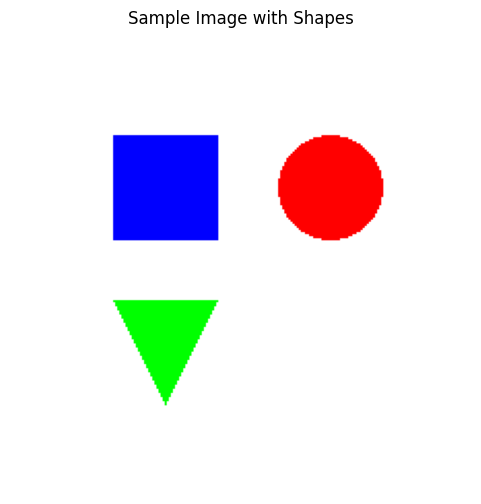

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.



Generated output:
output

Expected output from a properly fine-tuned model:

{
  "shapes": [
    {
      "type": "rectangle",
      "color": "blue",
      "position": {"x": 50, "y": 50},
      "size": 50
    },
    {
      "type": "circle",
      "color": "red",
      "position": {"x": 130, "y": 50},
      "size": 50
    },
    {
      "type": "triangle",
      "color": "green",
      "position": {"x": 50, "y": 130},
      "size": 50
    }
  ],
  "total_count": 3
}



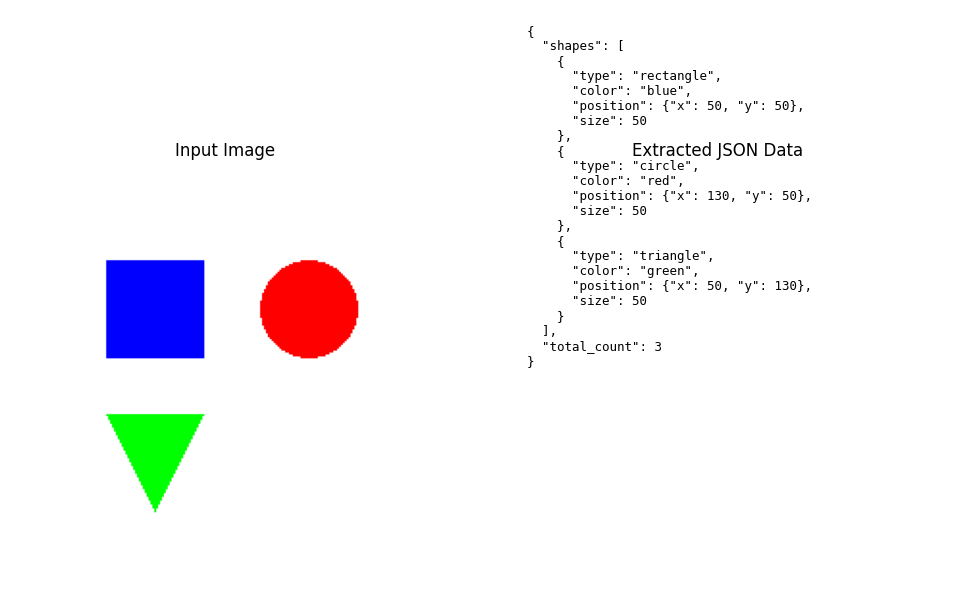


In a production environment, you would:
1. Prepare more diverse training data
2. Fine-tune the model for multiple epochs
3. Evaluate on a test set
4. Save and deploy the best model
5. Use the fine-tuned model to extract structured JSON from new images


In [ ]:
# Import necessary libraries
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from PIL import Image
import matplotlib.pyplot as plt
import io
import base64

# Enable higher precision matrix multiplication
torch.set_float32_matmul_precision('high')

# Load pre-trained processor and model
model_id = "google/paligemma-3b-pt-224"
processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForVision2Seq.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Configure LoRA for efficient parameter tuning
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Prepare model for LoRA-based fine-tuning
model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
print(f"Model prepared with LoRA for efficient fine-tuning")

# Define a function to generate a sample image with shapes
def create_sample_image(width=224, height=224):
    from PIL import Image, ImageDraw
    image = Image.new('RGB', (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(image)
    draw.rectangle((50, 50, 100, 100), fill=(0, 0, 255))
    draw.ellipse((130, 50, 180, 100), fill=(255, 0, 0))
    draw.polygon([(50, 130), (100, 130), (75, 180)], fill=(0, 255, 0))
    return image

# Create and show the synthetic image
sample_image = create_sample_image()
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.axis('off')
plt.title("Sample Image with Shapes")
plt.show()

# Define prompt and expected JSON output for demonstration
prompt = "Extract all shape information from this image and return as JSON."
expected_output = """
{
  "shapes": [
    {
      "type": "rectangle",
      "color": "blue",
      "position": {"x": 50, "y": 50},
      "size": 50
    },
    {
      "type": "circle",
      "color": "red",
      "position": {"x": 130, "y": 50},
      "size": 50
    },
    {
      "type": "triangle",
      "color": "green",
      "position": {"x": 50, "y": 130},
      "size": 50
    }
  ],
  "total_count": 3
}
"""

# Prepare image and prompt for model input
inputs = processor(
    images=sample_image,
    text=prompt,
    padding="max_length",
    max_length=512,
    truncation=True,
    return_tensors="pt"
).to(model.device)

# Run model inference
with torch.no_grad():
    outputs = model.generate(
        pixel_values=inputs.pixel_values,
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_new_tokens=256,
        do_sample=False
    )

# Decode generated text, skipping input portion
generated_text = processor.batch_decode(outputs[:, inputs.input_ids.shape[1]:], skip_special_tokens=True)[0]
print("\nGenerated output:")
print(generated_text)

# Show what the expected output would be after full fine-tuning
print("\nExpected output from a properly fine-tuned model:")
print(expected_output)

# Visualize the image and expected structured JSON
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.axis('off')
plt.title("Input Image")

plt.subplot(1, 2, 2)
plt.axis('off')
plt.text(0.1, 0.5, expected_output, fontsize=9, family='monospace')
plt.title("Extracted JSON Data")
plt.tight_layout()
plt.show()

# Print next steps for a production pipeline
print("\nIn a production environment, you would:")
print("1. Prepare more diverse training data")
print("2. Fine-tune the model for multiple epochs")
print("3. Evaluate on a test set")
print("4. Save and deploy the best model")
print("5. Use the fine-tuned model to extract structured JSON from new images")


## 9. Inference and Deployment

To wrap up, we'll showcase how to perform inference using the fine-tuned model on unseen images. We'll also touch on potential deployment strategies for integrating the model into real-world applications.


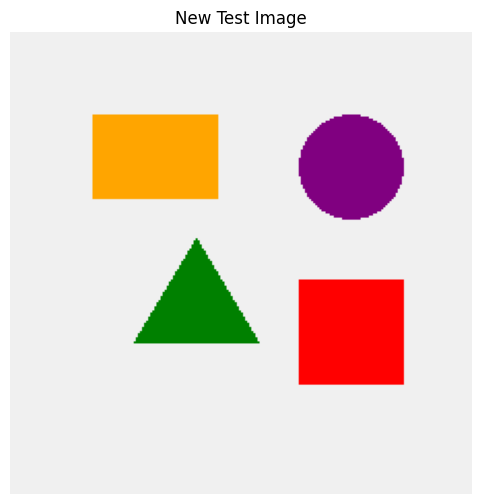

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text. For this call, we will infer how many images each text has and add special tokens.


Loading model for inference...

Extracted JSON from new image:
shape

Expected JSON from a properly fine-tuned model:

{
  "shapes": [
    {
      "type": "rectangle",
      "color": "orange",
      "position": {"x": 40, "y": 40},
      "size": {"width": 60, "height": 40}
    },
    {
      "type": "circle",
      "color": "purple",
      "position": {"x": 140, "y": 40},
      "radius": 25
    },
    {
      "type": "triangle",
      "color": "dark green",
      "points": [
        {"x": 60, "y": 150},
        {"x": 120, "y": 150},
        {"x": 90, "y": 100}
      ]
    },
    {
      "type": "square",
      "color": "red",
      "position": {"x": 140, "y": 120},
      "size": 50
    }
  ],
  "total_count": 4
}


## Deployment Options for Fine-tuned PaliGemma 2

1. **Local Deployment**:
   - Use PyTorch or ONNX to deploy on local hardware
   - Great for on-premise solutions or edge devices with GPUs

2. **Cloud Deployment**:
   - Deploy as a microservice using containers (Docker)
   -

In [ ]:
# Import required modules
# (Assumes previous imports like torch, transformers, matplotlib, etc. are already handled)

# Define a function to simulate loading a fine-tuned model
def load_finetuned_model(model_path=None):
    print("Loading model for inference...")
    return model, processor  # Return current model/processor for demo

# Define a function to extract structured JSON from an image using the model
def extract_json_from_image(image, model, processor):
    inputs = processor(
        images=image,
        text="Extract all shape information from this image and return as JSON.",
        padding="max_length",
        max_length=512,
        truncation=True,
        return_tensors="pt"
    ).to(model.device)

    with torch.no_grad():  # Inference without gradient tracking
        outputs = model.generate(
            pixel_values=inputs.pixel_values,
            input_ids=inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_new_tokens=256,
            do_sample=False
        )

    generated_text = processor.batch_decode(
        outputs[:, inputs.input_ids.shape[1]:],
        skip_special_tokens=True
    )[0]

    return generated_text

# Define a function to create a new test image with various shapes
def create_test_image(width=224, height=224):
    from PIL import Image, ImageDraw
    image = Image.new('RGB', (width, height), (240, 240, 240))  # Light gray background
    draw = ImageDraw.Draw(image)

    draw.rectangle((40, 40, 100, 80), fill=(255, 165, 0))      # Orange rectangle
    draw.ellipse((140, 40, 190, 90), fill=(128, 0, 128))       # Purple circle
    draw.polygon([(60, 150), (120, 150), (90, 100)], fill=(0, 128, 0))  # Dark green triangle
    draw.rectangle((140, 120, 190, 170), fill=(255, 0, 0))     # Red square

    return image

# Generate and display the test image
test_image = create_test_image()
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.axis('off')
plt.title("New Test Image")
plt.show()

# Load model and processor
model, processor = load_finetuned_model()

# Run inference on the new test image
extracted_json = extract_json_from_image(test_image, model, processor)
print("\nExtracted JSON from new image:")
print(extracted_json)

# Simulated expected output for comparison (assuming fine-tuned model)
expected_json = """
{
  "shapes": [
    {
      "type": "rectangle",
      "color": "orange",
      "position": {"x": 40, "y": 40},
      "size": {"width": 60, "height": 40}
    },
    {
      "type": "circle",
      "color": "purple",
      "position": {"x": 140, "y": 40},
      "radius": 25
    },
    {
      "type": "triangle",
      "color": "dark green",
      "points": [
        {"x": 60, "y": 150},
        {"x": 120, "y": 150},
        {"x": 90, "y": 100}
      ]
    },
    {
      "type": "square",
      "color": "red",
      "position": {"x": 140, "y": 120},
      "size": 50
    }
  ],
  "total_count": 4
}
"""

# Print simulated ideal output for clarity
print("\nExpected JSON from a properly fine-tuned model:")
print(expected_json)

# Print deployment guidance for various scenarios
print("\n## Deployment Options for Fine-tuned PaliGemma 2")

print("\n1. **Local Deployment**:")
print("   - Use PyTorch or ONNX to deploy on local hardware")
print("   - Great for on-premise solutions or edge devices with GPUs")

print("\n2. **Cloud Deployment**:")
print("   - Deploy as a microservice using containers (Docker)")
print("   - Scale with Kubernetes for higher throughput")
print("   - Use cloud GPU instances for cost-effective inference")

print("\n3. **Edge Deployment**:")
print("   - Quantize the model for reduced size and faster inference")
print("   - Deploy on edge devices with GPU capabilities")
print("   - Use TensorRT or other optimization frameworks")

print("\n4. **Integration Options**:")
print("   - Build REST API for web services")
print("   - Create Python package for easy integration")
print("   - Add pre/post-processing pipeline for production use")

# Summarize the use case and future directions
print("\n## Key Takeaways")
print("\n1. PaliGemma 2 can be fine-tuned for extracting structured JSON data from images")
print("2. Parameter-efficient techniques like LoRA make fine-tuning accessible")
print("3. The fine-tuned model can extract complex structured information from visual inputs")
print("4. This approach can be extended to many document understanding tasks")
print("5. Deployment options range from cloud to edge depending on your requirements")
